# Importação das Bibliotecas

In [16]:
# Importando bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from imblearn.under_sampling import RandomUnderSampler
import os

# Definição do caminho do dataset

In [17]:
CURRENT_DIRECTORY = os.getcwd()

# Definindo o caminho para o diretório 'data'
FILE_PATH = os.path.join(CURRENT_DIRECTORY, 'data')

# Definindo o caminho completo para o arquivo 'heart_2022_no_nans.csv'
FULL_FILE_PATH = os.path.join(FILE_PATH, 'heart_2022_no_nans.csv')

### Função para rodar e imprimir os resultados dos modelos

In [18]:
# Função para rodar e printar os resultados dos modelos
def evaluate_model(model, xtest, ytest):
    ypred = model.predict(xtest)
    acc = metrics.accuracy_score(ytest, ypred)
    prec = metrics.precision_score(ytest, ypred)
    rec = metrics.recall_score(ytest, ypred)
    f1 = metrics.f1_score(ytest, ypred)
    kappa = metrics.cohen_kappa_score(ytest, ypred)
    ypred_proba = model.predict_proba(xtest)[::,1]
    fpr, tpr, _ = metrics.roc_curve(ytest, ypred_proba)
    auc = metrics.roc_auc_score(ytest, ypred_proba)
    cm = metrics.confusion_matrix(ytest, ypred)
    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa, 'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}


# Leitura do Dataset


Nesta célula, carregamos o dataset e verificamos se há valores nulos, além de visualizar a distribuição da variável alvo.


In [19]:
# Abrir o dataset
print(FULL_FILE_PATH)
heart_data = pd.read_csv(FULL_FILE_PATH, encoding='unicode_escape')

# Verifica se existem valores nulos no dataset
print("Null values: ", heart_data.isna().values.any())

# Verifica distribuição da classe alvo do problema (vemos aqui que o dataset está desbalanceado)
print(heart_data['HadHeartAttack'].value_counts())


c:\Users\masar\Documents\UFF\Oitavo Semestre\IA\IACardio\app\data\heart_2022_no_nans.csv
Null values:  False
HadHeartAttack
No     232587
Yes     13435
Name: count, dtype: int64


## Visualização inicial dos dados

In [20]:
heart_data.info()  # coletando informações das colunas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  object 
 2   GeneralHealth              246022 non-null  object 
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  object 
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  object 
 9   HadHeartAttack             246022 non-null  object 
 10  HadAngina                  246022 non-null  object 
 11  HadStroke                  246022 non-null  object 
 12  HadAsthma                  246022 non-null  object 
 13  HadSkinCancer              24

Ao todo, existem 40 atributos no dataset, sendo 6 deles de tipos numéricos (indicados com float64). São eles:
- PhysicalHealthDays
- MentalHealthDays
- SleepHours
- HeightInMeters
- WeightInKilograms
- BMI

A descrição de cada atributo, [de acordo com a pesquisa feita pelo CDC](https://www.cdc.gov/brfss/annual_data/annual_2022.html), pode ser encontrada na tabela a seguir.

| Atributo                  | Descrição |
|:-------------------------:|:--------------------------------------------------------------------------------------------------------------------- |
| State                     | Estado (dos EUA) em que reside                                                                                        |
| Sex                       | Sexo biológico                                                                                                        |
| GeneralHealth             | Como a pessoa classifica sua saúde geral                                                                              |
| PhysicalHealthDays        | Por quantos dias dentre os 30 dias anteriores a saúde física da pessoa NÃO esteve boa                                  |
| MentalHealthDays          | Por quantos dias dentre os 30 dias anteriores a saúde mental da pessoa NÃO esteve boa                                  |
| LastCheckupTime           | Quando foi a última visita a um médico para checagem                                                                  |
| PhysicalActivities        | Se a pessoa praticou alguma atividade física nos 30 dias anteriores                                                   |
| SleepHours                | Tempo médio de sono                                                                                                   |
| RemovedTeeth              | Quantas vezes um dente permanente da pessoa teve de ser retirado por problemas dentários                              |
| HadHeartAttack            | Se já teve um infarto do miocárdio                                                                                    |
| HadAngina                 | Se já teve angina ou doença arterial coronariana (DAC)                                                                |
| HadStroke                 | Se já teve um acidente vascular cerebral (AVC)                                                                        |
| HadAsthma                 | Se já teve asma                                                                                                       |
| HadSkinCancer             | Se já teve câncer de pele que não fosse um melanoma                                                                   |
| HadCOPD                   | Se já teve doença pulmonar obstrutiva crônica (DPOC) ou bronquite crônica                                             |
| HadDepressiveDisorder     | Se já teve distúrbio depressivo                                                                                       |
| HadKidneyDisease          | Se já teve doença nos rins que não fosse pedras nos rins, incontingência urinária ou infeccção urinária               |
| HadArthritis              | Se já teve algum tipo de artrite                                                                                      |
| HadDiabetes               | Se já teve diabetes                                                                                                   |
| DeafOrHardOfHearing       | Se possui surdez ou alguma dificuldade auditiva                                                                       |
| BlindOrVisionDifficulty   | Se possui cegueira ou alguma dificuldade em enxergar (mesmo com óculos)                                               |
| DifficultyConcentrating   | Se possui alguma dificuldade de concentração ou memória                                                               |
| DifficultyWalking         | Se possui alguma dificuldade ao andar ou subir escadas                                                                |
| DifficultyDressingBathing | Se possui alguma dificuldade ao se vestir ou se banhar                                                                |
| DifficultyErrands         | Se possui alguma dificuldade em realizar tarefas cotidianas em virtude de alguma condição física, mental ou emocional |
| SmokerStatus              | Uso de cigarro comum                                                                                                  |
| ECigaretteUsage           | Uso de cigarro eletrônico                                                                                             |
| ChestScan                 | Se já fez alguma tomografia computadorizada da região do peito                                                        |
| RaceEthnicityCategory     | Raça/etnia autodeclarada                                                                                              |
| AgeCategory               | Idade (discretizada em categorias)                                                                                    |
| HeightInMeters            | Altura em metros                                                                                                      |
| WeightInKilograms         | Massa corporal em quilogramas                                                                                         |
| BMI                       | Índice de Massa Corporal (IMC)                                                                                        |
| AlcoholDrinkers           | Se consome bebidas alcoólicas regularmente                                                                            |
| HIVTesting                | Se alguma vez já foi testado para HIV                                                                                 |
| FluVaxLast12              | Se foi vacinado contra a gripe nos últimos 12 meses                                                                   |
| PneumoVaxEver             | Se alguma vez já foi vacinado contra pneumonia                                                                        |
| TetanusLast10Tdap         | Se foi vacinado contra tétano nos últimos 10 anos                                                                     |
| HighRiskLastYear          | Se a pessoa se envolveu em alguma das situações de alto risco a seguir no ano anterior: drogas ilícitas injetáveis; tratamento para alguma DST; pagamento ou recebimento de dinheiro ou droga em troca de favores sexuais.                                                         |
| CovidPos                  | Se já testou positivo para COVID-19                                                                                   |

# Pré-processamento


Nesta seção, realizamos o pré-processamento dos dados, que inclui a remoção de colunas irrelevantes, ajustes em variáveis categóricas, e criação de novas colunas. 

#### Ajuste de variáveis

- Conversão de variáveis para versões categóricas de "sim" e "não"

In [39]:
# DIABETES: SOMENTE SIM OU NÃO
heart_data['HadDiabetes'].replace({'No, pre-diabetes or borderline diabetes': 'Borderline', 'Yes, but only during pregnancy (female)': 'During Pregnancy'}, inplace=True)
heart_data['HadDiabetes'].unique()

# SMOKER: SOMENTE SIM OU NÃO
heart_data['SmokerStatus'].replace({'Current smoker - now smokes some days': 'Current smoker(Some days)', 'Current smoker - now smokes every day': 'Current smoker(Every day)'}, inplace=True)
heart_data['SmokerStatus'].unique()

# E-CIGARETTE: SOMENTE SIM OU NÃO
heart_data['ECigaretteUsage'].replace({'Not at all (right now)': 'Not at all', 'Never used e-cigarettes in my entire life': 'Never', 'Use them every day': 'Everyday', 'Use them some days': 'Somedays'}, inplace=True)
heart_data['ECigaretteUsage'].unique()

# COVID: SOMENTE SIM OU NÃO
heart_data['CovidPos'].replace({'Tested positive using home test without a health professional': 'Yes'}, inplace=True)
heart_data['CovidPos'].unique()


C:\Users\masar\AppData\Local\Temp\ipykernel_26544\778235384.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  heart_data['HadDiabetes'].replace({'No, pre-diabetes or borderline diabetes': 'Borderline', 'Yes, but only during pregnancy (female)': 'During Pregnancy'}, inplace=True)


KeyError: 'SmokerStatus'

- Simplificação das variáveis XX-XX ou 80+

In [24]:
# FAIXA ETÁRIA: SIMPLIFICAÇÃO DAS VARIÁVEIS XX-XX ou 80+
heart_data['AgeCategory'].replace({'Age 80 or older': '80+'}, inplace=True)
for value in heart_data['AgeCategory'].unique()[0:]:
    value = str(value)
    if value != 'nan' and value != '80+':
        cat_value = value.split(" ")
        heart_data['AgeCategory'].replace({value: cat_value[1] + "-" + cat_value[3]}, inplace=True)
heart_data['AgeCategory'].unique()

C:\Users\masar\AppData\Local\Temp\ipykernel_26544\2711425729.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  heart_data['AgeCategory'].replace({'Age 80 or older': '80+'}, inplace=True)


array(['65-69', '70-74', '75-79', '80+', '50-54', '40-44', '60-64',
       '55-59', '45-49', '35-39', '25-29', '30-34', '18-24'], dtype=object)

- Raça/Etnia reduzida a 4 opções

In [25]:
heart_data['RaceEthnicityCategory'].replace({'White only, Non-Hispanic': 'White', 'Black only, Non-Hispanic': 'Black', 'Other race only, Non-Hispanic': 'Other Race', 'Multiracial, Non-Hispanic': 'Multi Racial'}, inplace=True)
heart_data['RaceEthnicityCategory'].unique()

C:\Users\masar\AppData\Local\Temp\ipykernel_26544\437162397.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  heart_data['RaceEthnicityCategory'].replace({'White only, Non-Hispanic': 'White', 'Black only, Non-Hispanic': 'Black', 'Other race only, Non-Hispanic': 'Other Race', 'Multiracial, Non-Hispanic': 'Multi Racial'}, inplace=True)


array(['White', 'Black', 'Other Race', 'Multi Racial', 'Hispanic'],
      dtype=object)

#### Ajuste de colunas

- Remoção das seguintes colunas, irrelevantes para o problema

In [ ]:
heart_data = heart_data.drop(columns=['State', 'RemovedTeeth', 'LastCheckupTime', 'ChestScan', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 
                                      'TetanusLast10Tdap', 'HeightInMeters', 'WeightInKilograms'])

KeyError: "['State', 'RemovedTeeth', 'LastCheckupTime', 'ChestScan', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HeightInMeters', 'WeightInKilograms'] not found in axis"

- Criação da coluna SmokingHabit

In [ ]:
heart_data['SmokerStatus'].replace({'Current smoker(Some days)': 'Smoker', 'Current smoker(Every day)': 'Smoker'}, inplace=True)
heart_data['ECigaretteUsage'].replace({'Everyday': 'Smoker', 'Somedays': 'Smoker'}, inplace=True)
heart_data['SmokingHabit'] = np.where((heart_data['SmokerStatus'] == 'Smoker') | (heart_data['ECigaretteUsage'] == 'Smoker'), 'Smoker', 'Non-Smoker')
heart_data.drop(columns=['SmokerStatus', 'ECigaretteUsage'], inplace=True)

KeyError: 'SmokerStatus'

# Imprime as variáveis de cada classe após as simplificações

In [26]:
# Printa as variáveis de cada classe após as simplificações
for col in heart_data.describe(include='object').columns:
    print('Column Name: ', col)
    print(heart_data[col].unique())
    print('-' * 50)

Column Name:  Sex
['Female' 'Male']
--------------------------------------------------
Column Name:  GeneralHealth
['Very good' 'Fair' 'Good' 'Excellent' 'Poor']
--------------------------------------------------
Column Name:  PhysicalActivities
['Yes' 'No']
--------------------------------------------------
Column Name:  HadHeartAttack
['No' 'Yes']
--------------------------------------------------
Column Name:  HadAngina
['No' 'Yes']
--------------------------------------------------
Column Name:  HadStroke
['No' 'Yes']
--------------------------------------------------
Column Name:  HadAsthma
['No' 'Yes']
--------------------------------------------------
Column Name:  HadSkinCancer
['No' 'Yes']
--------------------------------------------------
Column Name:  HadCOPD
['No' 'Yes']
--------------------------------------------------
Column Name:  HadDepressiveDisorder
['No' 'Yes']
--------------------------------------------------
Column Name:  HadKidneyDisease
['No' 'Yes']
-----------

# Remoção de Entradas Duplicadas

Removemos entradas duplicadas para garantir que cada observação no dataset seja única.


In [27]:
heart_data.drop_duplicates(inplace=True)
print("Duplicadas: ", heart_data.shape)

Duplicadas:  (242357, 29)


# Conversão para Atributos Numéricos

- Convertendo variáveis categóricas para numéricas usando Label Encoding.


In [28]:
label = LabelEncoder()
for col in heart_data:
    heart_data[col] = label.fit_transform(heart_data[col])

# Matriz de Correlação

1. Calculamos a matriz de correlação de Pearson para verificar a correlação entre as variáveis do dataset.

1.1 - Correlação alta:

HadHeartAttack tem uma correlação moderada positiva com HadStroke (0.18), HadAngina (0.45), e HadCOPD (0.17). Isso sugere que pessoas que tiveram um ataque cardíaco também têm maior probabilidade de ter tido um derrame, angina ou COPD.
HadStroke também está correlacionado com HadCOPD (0.20), indicando que esses eventos de saúde podem ocorrer juntos em alguns pacientes.

1.2 - Correlação negativa:

PhysicalActivities tem uma correlação negativa moderada com DifficultyWalking (-0.26), DifficultyDressingBathing (-0.24), DifficultyErrands (-0.22), e DifficultyConcentrating (-0.16). Isso sugere que pessoas com mais atividades físicas tendem a ter menos dificuldades físicas.

1.3 - Interpretação de correlações específicas:

GeneralHealth tem correlações moderadas com HadDepressiveDisorder (0.42), HadCOPD (0.30), e HadArthritis (0.31), indicando que a saúde geral autoavaliada é influenciada por essas condições.
HadDepressiveDisorder tem uma correlação moderada com GeneralHealth (0.42), o que sugere que a presença de distúrbios depressivos pode afetar negativamente a percepção de saúde geral.
Variáveis com correlação quase nula:

Variáveis como Sex, AgeCategory, e RaceEthnicityCategory têm correlações muito baixas com a maioria das outras variáveis, sugerindo que elas têm pouca influência linear direta sobre as outras variáveis medidas no dataset.


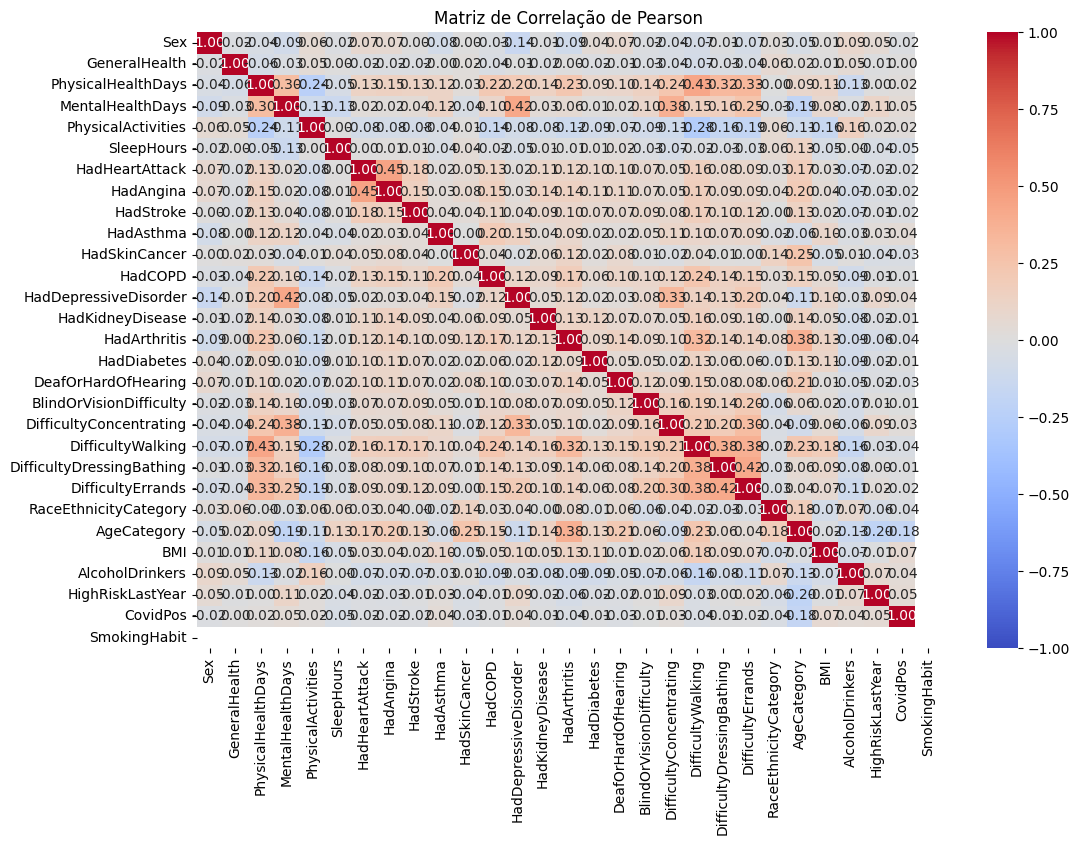

In [29]:
# Calcular a matriz de correlação de Pearson
correlation_matrix = heart_data.corr(method='pearson')

# Plotar a matriz de correlação como um mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Matriz de Correlação de Pearson')
plt.show()

# Separação dos Conjuntos Treino e Teste

Conjunto de Treino: Contém 70% dos dados e é usado para treinar o modelo.
Conjunto de Teste: Contém 30% dos dados e é usado para avaliar a performance do modelo em dados não vistos durante o treinamento.
train_test_split: Função do scikit-learn que facilita essa separação. O parâmetro random_state=42 é usado para garantir a reprodutibilidade dos resultados.

A proporção de 70/30 ou 80/20 é comum porque oferece um bom equilíbrio entre ter dados suficientes para treinar o modelo e dados suficientes para testar a performance do modelo.

In [30]:
# Separa classe alvo e as restantes
x = heart_data.drop('HadHeartAttack', axis=1)
y = heart_data['HadHeartAttack']

# Separa conjunto de treino e conjunto de teste
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=0.70, random_state=42)

# Transforma o vetor de destino y para ter uma dimensão unidimensional
y_train = np.ravel(ytrain)


# Undersampling do Dataset

RandomUnderSampler: Este método reduz o número de instâncias da classe majoritária para igualar o número de instâncias da classe minoritária, resultando em um dataset balanceado.
Random State: Garante reprodutibilidade dos resultados.
Normalização dos Dados: StandardScaler é usado para normalizar os dados, o que é uma prática comum antes de aplicar muitos algoritmos de aprendizado de máquina, especialmente aqueles que são sensíveis à escala dos dados, como regressão logística e SVM.

In [31]:
# Undersampling para balanceamento da classe alvo
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(x, y)
print(pd.Series(y_resampled).value_counts())

# Normalização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)


HadHeartAttack
0    13429
1    13429
Name: count, dtype: int64


# K-fold Crossvalidation

1. Redução do Overfitting:
Ao usar múltiplos folds, K-Fold Cross-Validation minimiza a tendência do modelo de superestimar sua própria performance, proporcionando uma avaliação mais precisa da sua capacidade de generalização. 
Fontes como "Pattern Recognition and Machine Learning" de Christopher Bishop discutem a importância de técnicas de validação cruzada para evitar overfitting.

2. Utilização Completa do Dataset:
Cada observação no dataset é usada tanto para treinamento quanto para teste. 
Isso maximiza o uso dos dados disponíveis, especialmente útil em datasets pequenos, como destacado em "The Elements of Statistical Learning" de Hastie, Tibshirani e Friedman.

3. Estimativa Robusta da Performance do Modelo:
K-Fold Cross-Validation fornece uma estimativa mais robusta da performance do modelo, já que o resultado final é a média dos resultados de todos os folds. 
Isso reduz a variação que pode resultar de uma única divisão dos dados, como discutido em "Introduction to Statistical Learning" pelos mesmos autores.

4. Desempenho Comparativo:
Permite a comparação eficaz entre diferentes modelos e parâmetros, utilizando a mesma estrutura de dados. 
Este método é essencial para selecionar o melhor modelo e ajustes de hiperparâmetros, como abordado em "Applied Predictive Modeling" por Kuhn e Johnson.

5. Parâmetros Específicos:

5.1 Número de Folds (n_splits=10): 10 é um valor comum que proporciona um bom equilíbrio entre viés e variância na estimativa da performance do modelo.

5.2 Shuffle=True: Mistura os dados antes de dividi-los em folds, garantindo que cada fold seja representativo da distribuição geral dos dados.

5.3 Random State: Garante reprodutibilidade dos resultados ao manter a consistência na forma como os dados são embaralhados e divididos em folds.

In [32]:
# K-Fold Cross-Validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Cálculo do K ótimo

In [33]:
# Assumindo que seus dados estão armazenados em X_scaled e y_resampled
# Range de valores K para testar
k_range = range(1, 45)
k_scores = []


# Avaliar o KNN para cada valor de K usando validação cruzada
for k in k_range:
   knn = KNeighborsClassifier(n_neighbors=k)
   scores = cross_val_score(knn, X_scaled, y_resampled, cv=10, scoring='accuracy')
   k_scores.append(scores.mean())

# # Plotar a acurácia para cada valor de K
# plt.figure(figsize=(8, 4))
# plt.plot(k_range, k_scores, 'bo-')
# plt.xlabel('Número de Vizinhos K')
# plt.ylabel('Acurácia')
# plt.title('Número ótimo de K para o KNN')
# plt.show()

# Melhor valor de K
optimal_k = k_range[np.argmax(k_scores)]
print(f'The optimal number of neighbors is {optimal_k}') 

KeyboardInterrupt: 

# Avaliação dos Modelos

1. Acurácia: Proporção de previsões corretas.
2. Precisão: Proporção de verdadeiros positivos entre as previsões positivas.
3. Recall: Proporção de verdadeiros positivos entre os casos positivos reais.
4. F1-Score: Média harmônica da precisão e recall.
5. ROC AUC: Área sob a curva ROC, que mede a capacidade do modelo em distinguir entre as classes.

In [ ]:
# Modelos
models = {
    'KNN': KNeighborsClassifier(n_neighbors=optimal_k),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Função para calcular métricas
def evaluate_model(model, X, y):
    metrics_dict = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1_score': make_scorer(f1_score, average='weighted'),
        'roc_auc': make_scorer(roc_auc_score, average='weighted', needs_proba=True, multi_class='ovr')
    }
    
    results = {}
    for metric_name, metric in metrics_dict.items():
        scores = cross_val_score(model, X, y, cv=kfold, scoring=metric)
        results[metric_name] = scores
    return results



KNN:
  accuracy: 0.7577 (+/- 0.0026)
  precision: 0.7585 (+/- 0.0025)
  recall: 0.7577 (+/- 0.0026)
  f1_score: 0.7576 (+/- 0.0026)
  roc_auc: 0.8250 (+/- 0.0030)
Logistic Regression:
  accuracy: 0.7897 (+/- 0.0048)
  precision: 0.7932 (+/- 0.0053)
  recall: 0.7897 (+/- 0.0048)
  f1_score: 0.7891 (+/- 0.0048)
  roc_auc: 0.8765 (+/- 0.0040)
Decision Tree:
  accuracy: 0.7106 (+/- 0.0076)
  precision: 0.7121 (+/- 0.0069)
  recall: 0.7116 (+/- 0.0069)
  f1_score: 0.7126 (+/- 0.0062)
  roc_auc: 0.7094 (+/- 0.0055)
Random Forest:
  accuracy: 0.7838 (+/- 0.0052)
  precision: 0.7838 (+/- 0.0036)
  recall: 0.7832 (+/- 0.0030)
  f1_score: 0.7825 (+/- 0.0034)
  roc_auc: 0.8700 (+/- 0.0043)


,accuracy,precision,recall,f1_score,roc_auc
KNN,"[0.7598659717051377, 0.7557706626954579, 0.754...","[0.7600323158947523, 0.7559073590629305, 0.756...","[0.7598659717051377, 0.7557706626954579, 0.754...","[0.7597355261385019, 0.7556539672494682, 0.754...","[0.8262499389976088, 0.821255689036844, 0.8233..."
Logistic Regression,"[0.7870439314966493, 0.7963514519731943, 0.792...","[0.7891338644424156, 0.7989076095293033, 0.798...","[0.7870439314966493, 0.7963514519731943, 0.792...","[0.7864511375544125, 0.7957165590382803, 0.792...","[0.8723164493502691, 0.8727125316581348, 0.882..."
Decision Tree,"[0.7073715562174236, 0.7073715562174236, 0.690...","[0.7111387992809208, 0.706407558041685, 0.6981...","[0.7036485480268057, 0.7017870439314966, 0.702...","[0.706985325313022, 0.7010586451531992, 0.7066...","[0.7081864654549004, 0.6954020215732823, 0.709..."
Random Forest,"[0.7792256142963514, 0.7755026061057334, 0.789...","[0.7866880254786905, 0.7769892687477712, 0.785...","[0.7866716306775875, 0.7795979151154132, 0.784...","[0.7810815336316035, 0.7795562234244796, 0.788...","[0.8644978837715893, 0.863071045651488, 0.8734..."


/home/milena/.local/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


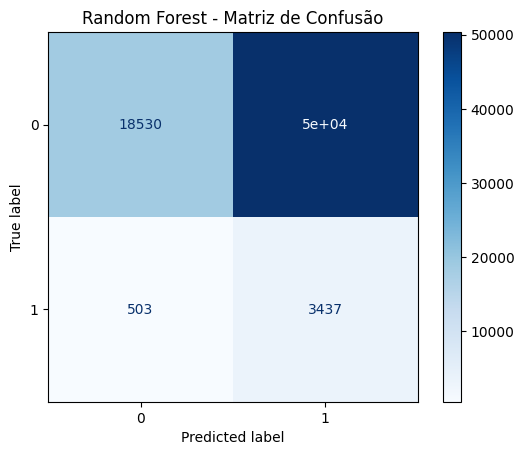

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Treinando o modelo Random Forest com todos os dados
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_scaled, y_resampled)

# Predições no conjunto de teste
y_pred = rf_model.predict(xtest)

# Calculando a matriz de confusão
cm = confusion_matrix(ytest, y_pred)

# Exibindo a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Random Forest - Matriz de Confusão')
plt.show()
